In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.ndimage import shift
from scipy.optimize import curve_fit
from scipy.spatial.distance import cdist
from scipy.ndimage import maximum_filter, label, find_objects

----

Gera a imagem de alta resolução.

----

In [6]:
def HR_image(image_01, image_02, dark):

#--------------------------------
# Carrega e abre os dados do fits
#--------------------------------
    HR_hdul = fits.open(image_01)
    HR_header = HR_hdul[0].header
    HR_data = HR_hdul[0].data

    HR_hdul_01 = fits.open(image_02)
    HR_header_01 = HR_hdul_01[0].header
    HR_data_01 = HR_hdul_01[0].data

    HR_hdul_master_dark = fits.open(dark)
    HR_header_master_dark = HR_hdul_master_dark[0].header
    HR_master_dark = HR_hdul_master_dark[0].data

#------------------------------------------------
# Função que calcula as imagens de alta resolução
#------------------------------------------------
    def hight_resolution_image(data, dark):
        num_frames, width, height = data.shape
        centro_y, centro_x = height//2, width//2
    
        AR_image = np.zeros((width, height))
    
        for i in range(num_frames):
            image = data[i] - dark # Pega a i-ésima imagem
            y_max, x_max = np.unravel_index(np.argmax(image), image.shape)

            dx = centro_x - x_max
            dy = centro_y - y_max
    
            imagem_alinhada = shift(image, shift=(dy, dx), order=1, mode='constant', cval=0.0) # Linha que alinha o centro das imagens do fits com o da imagem gerada (AR_image)

            AR_image +=imagem_alinhada

        return AR_image

    HR_01 = hight_resolution_image(HR_data, HR_master_dark)
    HR_02 = hight_resolution_image(HR_data_01, HR_master_dark)

    HR_mean = (HR_01 + HR_02) / 2

    return HR_mean

def position(image):

#--------------------------------
# Carrega e abre os dados do fits
#--------------------------------
    hdul_ar = fits.open(image)  # Mostra informações sobre as extensões do FITS
    header_ar = hdul_ar[0].header
    image_ar = hdul_ar[0].data  # Normalmente a imagem está na primeira extensão

    altura, largura = image_ar.shape

#---------------------------------------------------------------------------------
# Função que localiza e indica o valor do pico máximo (estrela primária) da imagem
#---------------------------------------------------------------------------------
    def fluxo_maximo(img):
        flux_max = np.amax(img) # Encontra o valor de máximo dentro da matriz (imagem)
        y_max, x_max = np.unravel_index(np.argmax(img), img.shape) # Encontra as coordenadas do máximo

        return (x_max, y_max)

#---------------------------------------------------------------------------------
# Função que localiza e indica os valores dos picos secundários (demais estrelas) da imagem
#---------------------------------------------------------------------------------
    def fluxo_secundário(img, num_picos, dist_minima=4, limiar_relativo=0.009):
        limiar = limiar_relativo * np.max(img)

        img_filtrada = maximum_filter(img, size=0.5)
        picos = (img == img_filtrada) & (img > limiar)

        y_coord, x_coord = np.where(picos)
        fluxo = img[y_coord, x_coord]
    
        indices_ord = np.argsort(fluxo)[::-1] # Ordena os valores do fluxo em ordem crescente
        fluxos_ord = fluxo[indices_ord]  
        posicoes_ord = np.column_stack((x_coord[indices_ord], y_coord[indices_ord])) # Gera um array 2D com os dados das posições dos picos secundários

        selecionados = [] # Essa looping está selecionando os "picos reais", desconsiderando aqueles pixels que estão ainda brilhantes devido ao mesmo pico
        for i, coord in enumerate(posicoes_ord):
            if all(np.linalg.norm(coord - np.array(outro)) >= dist_minima for outro in selecionados):
                selecionados.append(coord)
            if len(selecionados) >= num_picos:
                break
    
        selecionados = np.array(selecionados)
        fluxos_selecionados = [img[y, x] for x, y in selecionados]
    
        return selecionados

    posicoes = fluxo_secundário(image_ar, 2, dist_minima=4, limiar_relativo=0.009)

    (x_max, y_max) = fluxo_maximo(image_ar)
    posicoes_sec = posicoes[1:]

    altura, largura = image_ar.shape[:2]

    centro_x = largura/2
    centro_y = altura//2

    def distancia(x_c, y_c, x, y):
        d_x = x - x_c
        d_y = y - y_c
        d = np.sqrt((d_x**2) + (d_y)**2)
        theta = np.degrees(np.arctan(np.abs(d_y)/d_x))

        return d, theta
    
    dist, angulo = distancia(centro_x, centro_y, posicoes_sec[0, 0], posicoes_sec[0, 1])

    return dist, angulo

def magnitude(image):

#--------------------------------
# Carrega e abre os dados do fits
#--------------------------------
    hdul_ar = fits.open(image)  # Mostra informações sobre as extensões do FITS
    header_ar = hdul_ar[0].header
    image_ar = hdul_ar[0].data  # Normalmente a imagem está na primeira extensão

    altura, largura = image_ar.shape

#---------------------------------------------------------------------------------
# Função que localiza e indica o valor do pico máximo (estrela primária) da imagem
#---------------------------------------------------------------------------------
    def fluxo_maximo(img):
        flux_max = np.amax(img) # Encontra o valor de máximo dentro da matriz (imagem)
        y_max, x_max = np.unravel_index(np.argmax(img), img.shape) # Encontra as coordenadas do máximo

        return flux_max

#---------------------------------------------------------------------------------
# Função que localiza e indica os valores dos picos secundários (demais estrelas) da imagem
#---------------------------------------------------------------------------------
    def fluxo_secundário(img, num_picos, dist_minima=4, limiar_relativo=0.009):
        limiar = limiar_relativo * np.max(img)

        img_filtrada = maximum_filter(img, size=0.5)
        picos = (img == img_filtrada) & (img > limiar)

        y_coord, x_coord = np.where(picos)
        fluxo = img[y_coord, x_coord]
    
        indices_ord = np.argsort(fluxo)[::-1] # Ordena os valores do fluxo em ordem crescente
        fluxos_ord = fluxo[indices_ord]  
        posicoes_ord = np.column_stack((x_coord[indices_ord], y_coord[indices_ord])) # Gera um array 2D com os dados das posições dos picos secundários

        selecionados = [] # Essa looping está selecionando os "picos reais", desconsiderando aqueles pixels que estão ainda brilhantes devido ao mesmo pico
        for i, coord in enumerate(posicoes_ord):
            if all(np.linalg.norm(coord - np.array(outro)) >= dist_minima for outro in selecionados):
                selecionados.append(coord)
            if len(selecionados) >= num_picos:
                break
    
        selecionados = np.array(selecionados)
        fluxos_selecionados = [img[y, x] for x, y in selecionados]
    
        return fluxos_selecionados

    flux_sec = fluxo_secundário(image_ar, 2, dist_minima=4, limiar_relativo=0.009)

    flux_max = fluxo_maximo(image_ar)
    flux_sec = flux_sec[1:]

    def dif_mag(f_1, f_2):
        diferenca_de_magnitude = -2.5*np.log10((f_2/f_1))
        return diferenca_de_magnitude
    
    mag_dif = dif_mag(flux_max, flux_sec[0])
    
    return mag_dif

def seeing(image):
    LE_hdul = fits.open(image)
    LE_header_data = LE_hdul[0].header
    LE_data = LE_hdul[0].data

    def gaussian_2d(xy, amp, x0, y0, sigma_x, sigma_y, offset):
        x, y = xy
        g = offset + amp * np.exp(-(((x-x0)**2)/(2*sigma_x**2) + ((y-y0)**2)/(2*sigma_y**2)))
        return g.ravel()

#------------------------------------------------------
# Determina a posição do pixel mais brilhante da imagem
#------------------------------------------------------
    def pos_max(img):
        y_max, x_max = np.unravel_index(np.argmax(img), img.shape)
        return x_max, y_max

#-------------------------------------------------------------------
# Faz o recorte da região ao redor do ponto mais brilhante da imagem
#-------------------------------------------------------------------
    x_center, y_center = pos_max(LE_data) # Centraliza o corte no pixel mais brilhante
    width, height = LE_data.shape

#--------------------------------
# Coordenadas do ajuste Gaussiano
#-------------------------------- 
    yy, xx = np.indices(LE_data.shape)
    initial_guess = (LE_data.max(), x_center, y_center, width / 4, height / 4, np.median(LE_data))

#-------------------
# Ajusta a Gaussiana
#-------------------
    lower_bounds = [   0,       0,      0,      0.1,     0.1,     -np.inf ] # Linhas escrita para que sigma x e y sejam positivos
    upper_bounds = [ np.inf,  width, height,   np.inf,  np.inf,  np.inf ]

    popt, pcov = curve_fit(gaussian_2d, (xx, yy), LE_data.ravel(), p0=initial_guess, bounds=(lower_bounds, upper_bounds), maxfev=10000)

#---------------------------
# Extrai os valores de sigma
#---------------------------
    sigma_x, sigma_y = popt[3], popt[4]

#---------------
# Calcula a FWHM
#---------------
    fwhm_x = 2.355 * sigma_x
    fwhm_y = 2.355 * sigma_y
    fwhm_mean = (fwhm_x + fwhm_y) / 2

    escala = 0.06  # exemplo em arcsec/pixel
    seeing_arcsec = ((fwhm_x + fwhm_y)/2) * escala

    return seeing_arcsec   

In [ ]:
HR_mean, HR_01 = HR_image(r"D:\22abr22\22abr22\14040-4437-I-0050.fits", r"D:\22abr22\22abr22\14040-4437-I-0050.fits", r"D:\22abr22\Master_dark\space_master_dark300-0003.fits")

hdu = fits.PrimaryHDU(HR_mean)
hdu.writeto('teste_01.fits', overwrite=True)

----

Calcula o seeing da imagem de longa exposição.

----

FWHM X: 26.05 pixels
FWHM Y: 27.12 pixels
FWHM Média: 26.59 pixels
Seeing: 1.60 arcsec


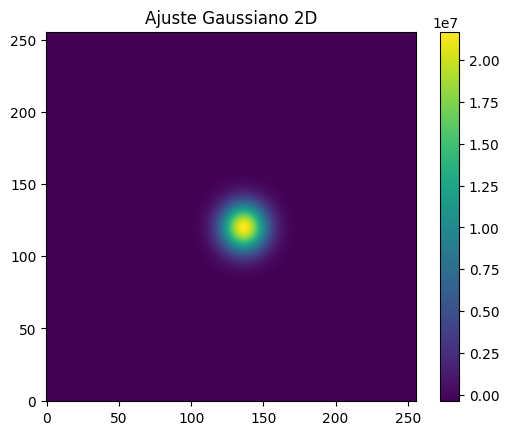

In [4]:
LE_hdul = fits.open(r"D:\22abr22\Longa_exposicao\LE_image-12283-6146_O-R.fits")
LE_header_data = LE_hdul[0].header
LE_data = LE_hdul[0].data

def gaussian_2d(xy, amp, x0, y0, sigma_x, sigma_y, offset):
    x, y = xy
    g = offset + amp * np.exp(-(((x-x0)**2)/(2*sigma_x**2) + ((y-y0)**2)/(2*sigma_y**2)))
    return g.ravel()

#------------------------------------------------------
# Determina a posição do pixel mais brilhante da imagem
#------------------------------------------------------
def pos_max(img):
    y_max, x_max = np.unravel_index(np.argmax(img), img.shape)
    return x_max, y_max

#-------------------------------------------------------------------
# Faz o recorte da região ao redor do ponto mais brilhante da imagem
#-------------------------------------------------------------------
x_center, y_center = pos_max(LE_data) # Centraliza o corte no pixel mais brilhante
width, height = LE_data.shape

#--------------------------------
# Coordenadas do ajuste Gaussiano
#-------------------------------- 
yy, xx = np.indices(LE_data.shape)
initial_guess = (LE_data.max(), x_center, y_center, width / 4, height / 4, np.median(LE_data))

#-------------------
# Ajusta a Gaussiana
#-------------------
lower_bounds = [   0,       0,      0,      0.1,     0.1,     -np.inf ] # Linhas escrita para que sigma x e y sejam positivos
upper_bounds = [ np.inf,  width, height,   np.inf,  np.inf,  np.inf ]

popt, pcov = curve_fit(gaussian_2d, (xx, yy), LE_data.ravel(), p0=initial_guess, bounds=(lower_bounds, upper_bounds), maxfev=10000)

#---------------------------
# Extrai os valores de sigma
#---------------------------
sigma_x, sigma_y = popt[3], popt[4]

#---------------
# Calcula a FWHM
#---------------
fwhm_x = 2.355 * sigma_x
fwhm_y = 2.355 * sigma_y
fwhm_mean = (fwhm_x + fwhm_y) / 2

print(f"FWHM X: {fwhm_x:.2f} pixels")
print(f"FWHM Y: {fwhm_y:.2f} pixels")
print(f"FWHM Média: {fwhm_mean:.2f} pixels")

#------------------------------
# Converte o seeing para arcsec
#------------------------------
escala = 0.06  # exemplo em arcsec/pixel
seeing_arcsec = ((fwhm_x + fwhm_y)/2) * escala
print(f"Seeing: {seeing_arcsec:.2f} arcsec")

data_fitted = gaussian_2d((xx, yy), *popt).reshape(LE_data.shape)
plt.plot
plt.title("Ajuste Gaussiano 2D")
plt.imshow(data_fitted, origin='lower', cmap='viridis')
plt.colorbar()
plt.show()